## Toy Regression Problem

### Dependencies

In [12]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import nuqls as nuqls
import neural_networks as nn
from importlib import reload
import swag as swag

torch.set_default_dtype(torch.float64)

### Create toy data

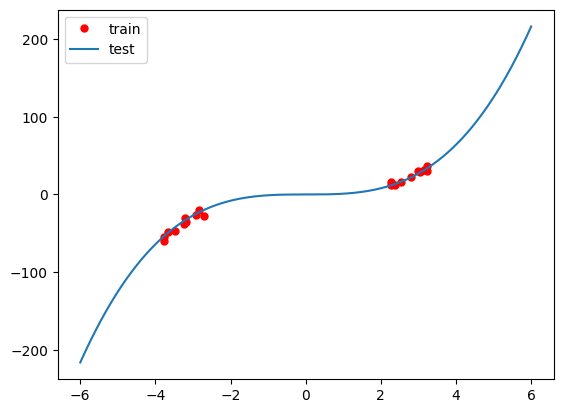

In [5]:
NUM_TRAIN_POINTS = 20
NUM_TEST_POINTS = 10000
std = 3
a1,a2,b1,b2 = -4,-2,2,4
c1,c2 = -6,6
eps = torch.randn((NUM_TRAIN_POINTS),1)*std
train_x = torch.cat((
    torch.rand((int(NUM_TRAIN_POINTS/2),1)) * (a2-a1) + a1,
    torch.rand((int(NUM_TRAIN_POINTS/2),1)) * (b2-b1) + b1
),dim=0)
train_y = torch.pow(train_x,3) + eps

train_y_std = train_y.std()
train_y_mean = train_y.mean()

test_x = torch.linspace(c1,c2,NUM_TEST_POINTS).reshape(-1,1)
test_y = torch.pow(test_x,3).reshape(-1,1)

## plot train
plt.plot(train_x.cpu().numpy().reshape(-1),train_y.cpu().numpy().reshape(-1),'ro',markersize=5,label='train')
plt.plot(test_x.cpu().numpy().reshape(-1),test_y.cpu().numpy().reshape(-1),label='test')
plt.legend()
plt.show()

In [6]:
class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
toy_train_loader = DataLoader(toy_dataset(train_x,train_y),NUM_TRAIN_POINTS)
toy_test_loader = DataLoader(toy_dataset(test_x,test_y),NUM_TEST_POINTS)

Using cpu device


  4%|▍         | 407/10000 [00:00<00:02, 4069.11it/s]

Train loss = 1161.245100660291


 13%|█▎        | 1292/10000 [00:00<00:02, 4083.31it/s]

Train loss = 56.4198004651593


 26%|██▌       | 2615/10000 [00:00<00:01, 4165.31it/s]

Train loss = 51.05872621960509


 35%|███▍      | 3454/10000 [00:00<00:01, 4169.09it/s]

Train loss = 41.73528426802785


 43%|████▎     | 4302/10000 [00:01<00:01, 4200.37it/s]

Train loss = 27.195607405162566


 56%|█████▋    | 5625/10000 [00:01<00:01, 4183.83it/s]

Train loss = 14.316022720663266


 65%|██████▌   | 6520/10000 [00:01<00:00, 4174.33it/s]

Train loss = 10.561292817357664


 74%|███████▎  | 7354/10000 [00:01<00:00, 4152.12it/s]

Train loss = 10.061102435282827


 87%|████████▋ | 8734/10000 [00:02<00:00, 4155.07it/s]

Train loss = 9.768411203203923


 96%|█████████▋| 9632/10000 [00:02<00:00, 4156.36it/s]

Train loss = 9.543185301265323


100%|██████████| 10000/10000 [00:02<00:00, 4158.46it/s]

Done!


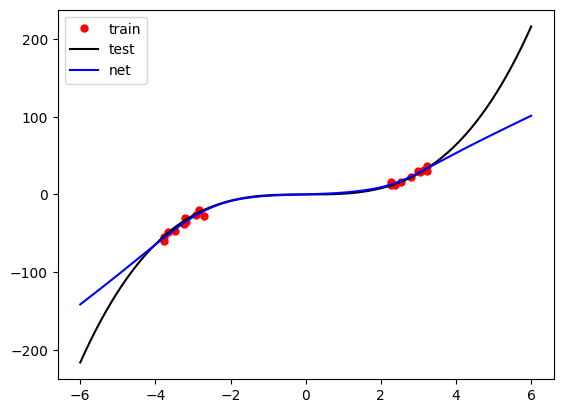

In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

## Set up neural network.
width = 50

class oneLayerMLP(torch.nn.Module):
    def __init__(self, width):
        super().__init__()
        self.output_size = 1
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, width),
            torch.nn.SiLU(),
            torch.nn.Linear(width, 1)
        )

    def forward(self, x):
        output = self.net(x)
        return output
    

## MSE Model
map_net = oneLayerMLP(width).to(device)
map_net.apply(nn.weights_init)

map_epochs = 10000
map_lr = 0.001
map_wd = 0

mse_loss = torch.nn.MSELoss()
optimizer_MSE = torch.optim.Adam(map_net.parameters(), lr = map_lr, weight_decay=map_wd)
scheduler_MSE = torch.optim.lr_scheduler.PolynomialLR(optimizer_MSE, map_epochs, 0.5)

## Training loop
def train(X, y, model, loss_fn, optimizer, scheduler):
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    return loss.item()

def test(X, y, model, loss_fn):
    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    return loss.item()

train_MSE = True
if train_MSE:
    for t in tqdm(range(map_epochs)):
        train_loss = train(train_x, train_y, map_net, mse_loss, optimizer_MSE, scheduler_MSE)
        if t % (map_epochs / 10) == 0:
            print("Train loss = {}".format(train_loss))
    print("Done!")

## plot train
plt.plot(train_x.cpu().numpy().reshape(-1),train_y.cpu().numpy().reshape(-1),'ro',markersize=5,label='train')
plt.plot(test_x.cpu().numpy().reshape(-1),test_y.cpu().numpy().reshape(-1),'k',label='test')
plt.plot(test_x.cpu().numpy().reshape(-1), map_net(test_x).detach().cpu().numpy().reshape(-1), 'b', label='net')
plt.legend()
plt.show()

In [9]:
reload(nuqls)

train_data = toy_dataset(train_x,train_y)
test_data = toy_dataset(test_x,test_y)

nuql_test_preds, res = nuqls.linear_sampling(map_net, train_data, test_data, ood_test_data=None, regression= 'True', train_bs = 100, test_bs = 100, S = 10, scale=5, lr=1e-3, epochs=1000, mu=0.9, verbose=False)
nuql_mu = nuql_test_preds.mean(0)
nuql_var = nuql_test_preds.var(0)
print(res)

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:101: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional_with_buffers is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional_with_buffers', 'torch.func.functional_call')
100%|██████████| 10/10 [00:07<00:00,  1.25it/s]

{'loss': tensor(9.7331, grad_fn=<DivBackward0>), 'acc': 0}


In [10]:
## Deep Ensemble - Heteroskedastic Variance
WIDTH = width

def to_np(x):
    return x.cpu().detach().numpy()

class EnsembleNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(1,WIDTH)
        self.relu = torch.nn.SiLU()
        self.linear_mu = torch.nn.Linear(WIDTH,1)
        self.linear_sig = torch.nn.Linear(WIDTH,1)

    def forward(self, x):
        x = self.relu(self.linear_1(x))
        mu = self.linear_mu(x)
        variance = self.linear_sig(x)
        variance = torch.nn.functional.softplus(variance) + 1e-6
        return mu, variance

class CustomNLL(torch.nn.Module):
    def __init__(self):
        super(CustomNLL, self).__init__()

    def forward(self, y, mean, var):
        
        loss = (0.5*torch.log(var) + 0.5*(y - mean).pow(2)/var).mean() + 1

        if np.any(np.isnan(to_np(loss))):
            print(torch.log(var))
            print((y - mean).pow(2)/var)
            raise ValueError('There is Nan in loss')
        
        return loss

M = 10
de_lr = 0.05
de_epochs = 5000
de_wd = 0

model_list = []
opt_list = []
sched_list = []

for i in range(M):
    model_list.append(EnsembleNetwork().to(device))
    model_list[i].apply(nn.weights_init)
    opt_list.append(torch.optim.Adam(model_list[i].parameters(), lr = de_lr, weight_decay=de_wd))
    sched_list.append(torch.optim.lr_scheduler.PolynomialLR(opt_list[i], de_epochs, 0.5))

NLL = CustomNLL()

def train_heteroskedastic(X,y,net,loss,optim,sched):
    # Compute prediction error
    pred, var = net(X)
    loss = loss(y, pred, var)

    # Backpropagation
    loss.backward()

    optim.step()
    # sched.step()
    optim.zero_grad()

    return loss.item()

train_ensembles = True
if train_ensembles:
    for i in range(M):
        print("\nTraining model {}".format(i))
        for t in range(de_epochs):
            train_loss = train_heteroskedastic(train_x, train_y, model_list[i], NLL, opt_list[i], sched_list[i])
            if t % (de_epochs / 10) == 0:
                print("NLL loss = {}".format(train_loss))
                test_pred,test_var = model_list[i](train_x)
                mle_loss = mse_loss(test_pred,train_y)
                print("MSE loss = {}".format(mle_loss))
        print("Done!")

ensemble_het_mu = torch.empty((M,NUM_TEST_POINTS))
ensemble_het_var = torch.empty((M,NUM_TEST_POINTS))
for i in range(M):
    mu, var = model_list[i](test_x)
    ensemble_het_mu[i,:] = mu.reshape(1,-1)
    ensemble_het_var[i,:] = var.reshape(1,-1)
ensemble_het_mu_mean = torch.mean(ensemble_het_mu,dim=0)
ensemble_het_var_mean = torch.mean(ensemble_het_var + torch.square(ensemble_het_mu), dim=0) - torch.square(ensemble_het_mu_mean)


Training model 0
NLL loss = 5766.385010496937
MSE loss = 1139.6689076331688
NLL loss = 4.043815444274819
MSE loss = 63.105917871011684
NLL loss = 3.8076693247012146
MSE loss = 59.90421904358514
NLL loss = 3.4998001617767818
MSE loss = 53.1666401427898
NLL loss = 3.182019723450924
MSE loss = 45.64921738740861
NLL loss = 2.985563398793128
MSE loss = 37.7305005249017
NLL loss = 2.838446912712695
MSE loss = 26.69425843422302
NLL loss = 2.701821877108161
MSE loss = 15.549005861670096
NLL loss = 2.6235357459998325
MSE loss = 10.731611344962989
NLL loss = 2.5884762300919837
MSE loss = 10.183217980935206
Done!

Training model 1
NLL loss = 22586.108035976293
MSE loss = 1094.4281490760372
NLL loss = 4.5031994975549585
MSE loss = 61.89614894892061
NLL loss = 4.223538663042547
MSE loss = 59.99297586638748
NLL loss = 3.9726607727461802
MSE loss = 57.45939174862874
NLL loss = 3.760617563919617
MSE loss = 54.573111525748615
NLL loss = 3.5664566878516766
MSE loss = 51.0239075297586
NLL loss = 3.37122

In [11]:
reload(swag)

swag_net = oneLayerMLP(WIDTH).to(device)
swag_net.apply(nn.weights_init)

optimizer_MSE = torch.optim.Adam(swag_net.parameters(), lr = map_lr, weight_decay=map_wd)
scheduler_MSE = torch.optim.lr_scheduler.PolynomialLR(optimizer_MSE, map_epochs, 0.5)

for t in tqdm(range(map_epochs)):
    train_loss = train(train_x, train_y, swag_net, mse_loss, optimizer_MSE, scheduler_MSE)
    if t % (map_epochs / 10) == 0:
        print("Train loss = {}".format(train_loss))
print("Done!")

swag_method = swag.SWAG_R(swag_net,epochs = map_epochs, lr = map_lr, cov_mat = True,
                            max_num_models=10)
swag_method.train_swag(train_x,train_y)

T = 1000
swag_pred_samples = torch.empty((T,NUM_TEST_POINTS),device='cpu')
for t in range(T):
    swag_method.sample(cov=True)
    swag_pred_samples[t,:] = swag_method(test_x).reshape(-1)
swag_pred = swag_pred_samples.mean(axis=0)
swag_var = swag_pred_samples.var(axis=0)

  9%|▉         | 876/10000 [00:00<00:02, 4244.38it/s]

Train loss = 1158.0979714929158


 13%|█▎        | 1301/10000 [00:00<00:02, 4237.31it/s]

Train loss = 57.74102417135573


 26%|██▌       | 2610/10000 [00:00<00:01, 4119.81it/s]

Train loss = 47.33708455984517


 35%|███▍      | 3471/10000 [00:00<00:01, 4082.64it/s]

Train loss = 33.44041333657643


 47%|████▋     | 4728/10000 [00:01<00:01, 4135.73it/s]

Train loss = 21.858485288620052


 56%|█████▌    | 5556/10000 [00:01<00:01, 4126.50it/s]

Train loss = 14.303346745307811


 64%|██████▍   | 6437/10000 [00:01<00:00, 4133.12it/s]

Train loss = 11.087886489822434


 77%|███████▋  | 7731/10000 [00:01<00:00, 4002.77it/s]

Train loss = 10.154703797279485


 85%|████████▌ | 8528/10000 [00:02<00:00, 3931.46it/s]

Train loss = 9.796010002210341


 93%|█████████▎| 9320/10000 [00:02<00:00, 3928.44it/s]

Train loss = 9.58091035337214


100%|██████████| 10000/10000 [00:02<00:00, 4066.88it/s]


Done!


In [1]:
from posteriors.lla.models import MLPS
from posteriors.lla.likelihoods import GaussianLh
from posteriors.lla.datasets import SnelsonGen
from posteriors.lla.laplace import Laplace

prior_prec = 0.1
lh = GaussianLh(sigma_noise=3)  # fixed to true noise

lap = Laplace(map_net, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(toy_train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(test_x, n_samples=1000)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(test_x, n_samples=1000)
        mu, var = samples.mean(dim=0), samples.var(dim=0)
    else:
        raise ValueError('unsupported model_type.')
    # mu = mu.detach().cpu().squeeze().numpy()
    # var = var.detach().cpu().squeeze().numpy()
    return mu.reshape(-1,1), var.reshape(-1,1)

# LLA
mu_glm_full, var_glm_full = get_pred_for('glm', 'full')



ModuleNotFoundError: No module named 'posterior'

In [14]:
prior_prec = 1
lh = GaussianLh(sigma_noise=3)  # fixed to true noise

lap = Laplace(map_net, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    #### INFERENCE (Posterior approximation) ####
    lap.infer(toy_train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        #### GLM PREDICTIVE ####
        mu, var = lap.predictive_samples_glm(test_x, n_samples=1000)
    elif model_type == 'bnn':
        #### BNN PREDICTIVE ####
        samples = lap.predictive_samples_bnn(test_x, n_samples=1000)
        mu, var = samples.mean(dim=0), samples.var(dim=0)
    else:
        raise ValueError('unsupported model_type.')
    # mu = mu.detach().cpu().squeeze().numpy()
    # var = var.detach().cpu().squeeze().numpy()
    return mu.reshape(-1,1), var.reshape(-1,1)

# LA
mu_bnn_full, var_bnn_full = get_pred_for('bnn', 'full')

In [15]:
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from copy import deepcopy

const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 3.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 1,
}

vi_net = deepcopy(map_net)
    
dnn_to_bnn(vi_net, const_bnn_prior_parameters)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(vi_net.parameters(), 1e-3, weight_decay=0)

for _ in range(10000):
    output = vi_net(train_x)
    kl = get_kl_loss(vi_net)
    ce_loss = criterion(output, train_y)
    loss = ce_loss + kl

    loss.backward()
    optimizer.step()
    print(f"loss = {loss}")

vi_net.eval()
with torch.no_grad():
    output_mc = []
    for mc_run in range(1000):
        output = vi_net(test_x)
        output_mc.append(output)
    output = torch.stack(output_mc)  
    mu_vi = output.mean(0)
    var_vi = output.var(0)


loss = 1148.3784705291625
loss = 1148.984286554267
loss = 1129.3234106189443
loss = 1137.123194747108
loss = 1137.052484811398
loss = 1137.8006336912945
loss = 1138.068559848193
loss = 1134.553981050161
loss = 1134.031070621161
loss = 1134.8598615652857
loss = 1138.12584821969
loss = 1136.1217470092804
loss = 1129.7393722135612
loss = 1130.1351947737492
loss = 1135.3558581025698
loss = 1134.7753967377932
loss = 1126.2717707245847
loss = 1114.0411883335332
loss = 1126.2267391555386
loss = 1115.6505894062902
loss = 1128.5270958666388
loss = 1125.1560718218332
loss = 1121.4203779141246
loss = 1110.1329776398127
loss = 1121.2754794378818
loss = 1112.5900769842876
loss = 1112.591178205404
loss = 1113.9223037762235
loss = 1111.820290317079
loss = 1110.82560899656
loss = 1114.6060814938146
loss = 1112.087917900834
loss = 1115.7010886267708
loss = 1101.612042484685
loss = 1091.0243324961207
loss = 1103.3382011797205
loss = 1107.3561791357715
loss = 1108.5007468525819
loss = 1092.4292522691067


In [16]:
## Plot
def plot_torch(x):
    return x.detach().cpu().numpy().reshape(-1)

def plot_bayes_method(ax,mean,var,title,fs,ms,lw):
    ax.plot(plot_torch(train_x),plot_torch(train_y),'ro',markersize=ms)
    ax.plot(plot_torch(test_x),plot_torch(test_y),'k',linewidth=lw)
    ax.plot(plot_torch(test_x),plot_torch(mean),'b',linewidth=lw)

    ci = torch.sqrt(var)*3
    y1, y2 = mean - ci, mean + ci

    ax.fill_between(plot_torch(test_x), plot_torch(y1), plot_torch(y2), color='g', alpha=.4)

    ax.set_title(title, fontsize=fs)
    ax.set_yticks(np.array((-200,0,200)))
    ax.set_ylim([-300,300])
    ax.tick_params(axis='both', which='major', labelsize=fs)


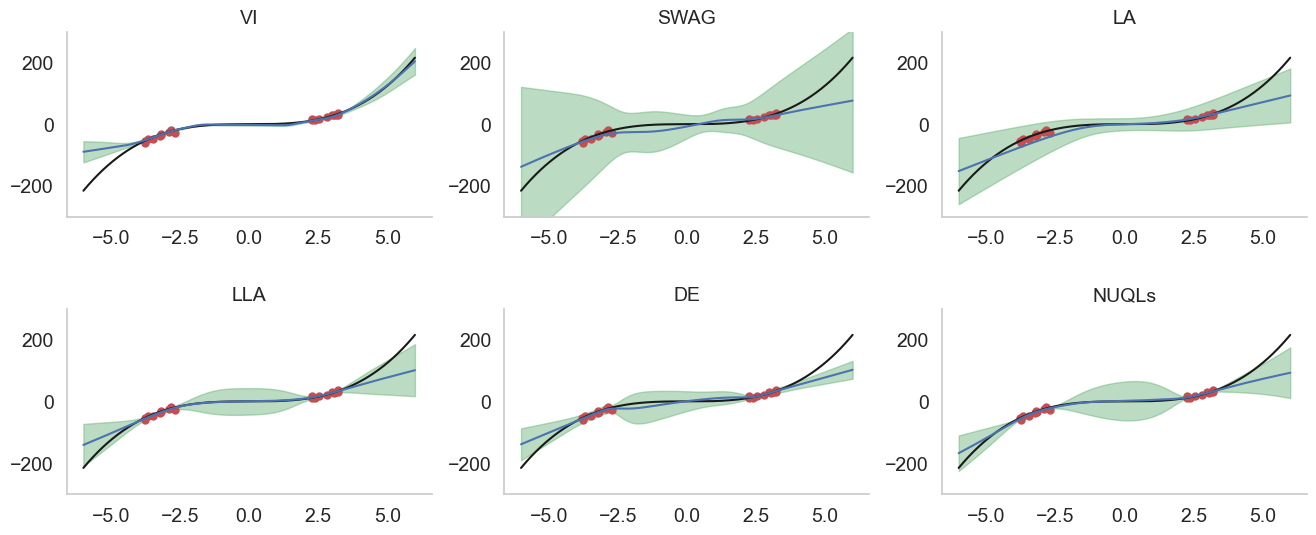

In [17]:
fs, ms, lw = 14, 5, 1.5

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 

f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)

f.set_figheight(6)
f.set_figwidth(16)
f.subplots_adjust(hspace=0.5)

## Plot VI
plot_bayes_method(ax1,mu_vi,var_vi,'VI',fs=fs, ms=ms, lw=lw)

## Plot SWAG
plot_bayes_method(ax2,swag_pred,swag_var,'SWAG',fs=fs, ms=ms, lw=lw)

## LA
plot_bayes_method(ax3,mu_bnn_full,var_bnn_full,'LA',fs=fs, ms=ms, lw=lw)

## Plot LLA
plot_bayes_method(ax4,mu_glm_full,var_glm_full,'LLA',fs=fs, ms=ms, lw=lw)

## Plot DE
plot_bayes_method(ax5,ensemble_het_mu_mean,ensemble_het_var_mean,'DE',fs=fs, ms=ms, lw=lw)

## Plot NUQLs
plot_bayes_method(ax6,nuql_mu,nuql_var,'NUQLs',fs=fs, ms=ms, lw=lw)

plt.savefig("UncertaintyComparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [18]:
from functorch import make_functional
from torch.func import vmap, jacrev

def l_layer_params(net):
    theta_star_k = []
    sd = net.state_dict()
    sdk = sd.keys()
    print(len(sdk))
    for i,p in enumerate(sdk):
        if i < len(sdk) - 2:
            theta_star_k.append(sd[p].flatten(0))
        else:
            theta_star_k.append(torch.zeros(sd[p].flatten(0).shape))
    theta_star_k = torch.cat(theta_star_k)
    return theta_star_k

def flatten(lst):
    tmp = [i.contiguous().view(-1, 1) for i in lst]
    return torch.cat(tmp).view(-1)

M = 10
learning_rate = 0.01
epochs = 10000
weight_decay = 0
sigma2 = std**2

model_list = []
opt_list = []
sched_list = []

loss = mse_loss
bde_preds = torch.empty((M,NUM_TEST_POINTS))

def train_bde(X,y,net,delta,theta_k,loss,Lambda,optim,sched):
    # Compute prediction error
    pred = net(X)

    # Add delta function to outputs
    pred = pred + delta

    # Calculate loss
    loss = loss(y, pred)

    # Regularisation
    theta_t = torch.nn.utils.parameters_to_vector(net.parameters())
    diff = theta_t - theta_k
    reg = diff @ (Lambda * diff)
    loss = 0.5 * loss + 0.5 * reg

    # Backpropagation
    loss.backward()

    optim.step()
    if sched is not None:
        sched.step()
    optim.zero_grad()

    return loss.item()

def bde_weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.normal_(m.bias,mean=0,std=1)

for i in range(M):
    bde_model1 = nn.twoLayerMLP(width).to(device)
    bde_model1.apply(bde_weights_init)
    opt = torch.optim.Adam(bde_model1.parameters(), lr = map_lr, weight_decay=map_wd)
    sched = torch.optim.lr_scheduler.PolynomialLR(opt, map_epochs, 0.5)

    ## Find theta~
    bde_model2 = nn.twoLayerMLP(width).to(device)
    bde_model2.apply(nn.weights_init) 
    theta_star_k = l_layer_params(bde_model2)

    ## Create delta functions
    fnet, params = make_functional(bde_model1)
    def jacobian(x):
        def fnet_single(params, x):
            return fnet(params, x.unsqueeze(0)).squeeze(0)
        J = vmap(jacrev(fnet_single), (None, 0))(params, x.to(device))
        J = [j.detach().flatten(1) for j in J]
        J = torch.cat(J,dim=1).detach()
        return J
    delta = lambda x : jacobian(x) @ theta_star_k
    train_delta = delta(train_x)

    ## Save theta_k
    theta_k = torch.nn.utils.parameters_to_vector(bde_model1.parameters()).detach().clone()

    ## Create Mahalanobis matrix
    Lambda = 1 / sigma2

    ## Train ensemble member
    print("\nTraining model {}".format(i))
    for t in tqdm(range(map_epochs)):
        train_loss = train_bde(train_x, train_y, bde_model1, train_delta, theta_k, mse_loss, Lambda, opt, sched)
        if t % (epochs / 10) == 0:
            print("train loss = {:.4f}".format(train_loss))
    print("Done!")

    # Get predictions
    bde_pred = bde_model1(test_x).reshape(-1) + delta(test_x).reshape(-1)
    bde_preds[i,:] = bde_pred

bde_mean = torch.mean(bde_preds,dim=0)
bde_var = torch.var(bde_preds,dim=0) # + std**2

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


6

Training model 0


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20, 20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 119/10000 [00:00<00:08, 1187.69it/s]

train loss = 599.3171


 12%|█▏        | 1184/10000 [00:00<00:06, 1297.20it/s]

train loss = 19.8803


 21%|██        | 2111/10000 [00:01<00:06, 1279.10it/s]

train loss = 9.2236


 32%|███▏      | 3198/10000 [00:02<00:05, 1271.89it/s]

train loss = 8.1014


 42%|████▏     | 4175/10000 [00:03<00:04, 1355.14it/s]

train loss = 7.7250


 51%|█████▏    | 5144/10000 [00:03<00:03, 1347.28it/s]

train loss = 7.4963


 62%|██████▏   | 6192/10000 [00:04<00:03, 1267.48it/s]

train loss = 7.3332


 72%|███████▏  | 7179/10000 [00:05<00:02, 1162.89it/s]

train loss = 7.2042


 82%|████████▏ | 8212/10000 [00:06<00:01, 1215.97it/s]

train loss = 7.0843


 93%|█████████▎| 9284/10000 [00:07<00:00, 1336.13it/s]

train loss = 6.9791


100%|██████████| 10000/10000 [00:07<00:00, 1264.92it/s]


Done!
6

Training model 1


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 520.5321


 12%|█▏        | 1187/10000 [00:00<00:07, 1258.80it/s]

train loss = 13.2424


 21%|██        | 2106/10000 [00:01<00:06, 1278.61it/s]

train loss = 8.5093


 32%|███▏      | 3155/10000 [00:02<00:05, 1293.80it/s]

train loss = 7.8880


 42%|████▏     | 4217/10000 [00:03<00:04, 1278.79it/s]

train loss = 7.4617


 51%|█████▏    | 5141/10000 [00:04<00:03, 1270.01it/s]

train loss = 7.2014


 62%|██████▏   | 6195/10000 [00:04<00:03, 1252.04it/s]

train loss = 7.0148


 71%|███████   | 7112/10000 [00:05<00:02, 1261.62it/s]

train loss = 6.8757


 82%|████████▏ | 8157/10000 [00:06<00:01, 1285.24it/s]

train loss = 6.7640


 92%|█████████▏| 9220/10000 [00:07<00:00, 1263.21it/s]

train loss = 6.6847


100%|██████████| 10000/10000 [00:07<00:00, 1275.58it/s]


Done!
6

Training model 2


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 617.7482


 12%|█▏        | 1176/10000 [00:00<00:06, 1261.99it/s]

train loss = 25.0410


 22%|██▏       | 2152/10000 [00:01<00:05, 1352.63it/s]

train loss = 9.3187


 32%|███▏      | 3153/10000 [00:02<00:04, 1369.96it/s]

train loss = 8.4100


 42%|████▏     | 4151/10000 [00:03<00:04, 1361.60it/s]

train loss = 8.0310


 52%|█████▏    | 5153/10000 [00:03<00:03, 1369.60it/s]

train loss = 7.7846


 63%|██████▎   | 6258/10000 [00:04<00:02, 1363.77it/s]

train loss = 7.6415


 72%|███████▏  | 7238/10000 [00:05<00:01, 1381.52it/s]

train loss = 7.4942


 82%|████████▏ | 8205/10000 [00:06<00:01, 1378.49it/s]

train loss = 7.3056


 92%|█████████▏| 9162/10000 [00:06<00:00, 1356.20it/s]

train loss = 7.1217


100%|██████████| 10000/10000 [00:07<00:00, 1347.34it/s]


Done!
6

Training model 3


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 599.8690


 12%|█▏        | 1238/10000 [00:00<00:06, 1371.94it/s]

train loss = 25.9130


 22%|██▏       | 2239/10000 [00:01<00:05, 1374.98it/s]

train loss = 9.7773


 32%|███▏      | 3223/10000 [00:02<00:05, 1338.15it/s]

train loss = 8.5147


 42%|████▏     | 4205/10000 [00:03<00:04, 1376.80it/s]

train loss = 8.1354


 52%|█████▏    | 5178/10000 [00:03<00:03, 1387.96it/s]

train loss = 7.9172


 62%|██████▏   | 6151/10000 [00:04<00:02, 1384.36it/s]

train loss = 7.7041


 73%|███████▎  | 7260/10000 [00:05<00:01, 1376.10it/s]

train loss = 7.2997


 82%|████████▏ | 8231/10000 [00:06<00:01, 1352.80it/s]

train loss = 7.0769


 92%|█████████▏| 9212/10000 [00:06<00:00, 1373.21it/s]

train loss = 6.9749


100%|██████████| 10000/10000 [00:07<00:00, 1363.34it/s]


Done!
6

Training model 4


  1%|▏         | 135/10000 [00:00<00:07, 1336.70it/s]

train loss = 612.8692


 13%|█▎        | 1267/10000 [00:00<00:06, 1387.15it/s]

train loss = 16.9513


 23%|██▎       | 2251/10000 [00:01<00:05, 1358.04it/s]

train loss = 9.1327


 32%|███▏      | 3232/10000 [00:02<00:04, 1372.73it/s]

train loss = 7.9053


 42%|████▏     | 4221/10000 [00:03<00:04, 1382.74it/s]

train loss = 7.3648


 52%|█████▏    | 5228/10000 [00:03<00:03, 1378.09it/s]

train loss = 6.9337


 62%|██████▏   | 6186/10000 [00:04<00:02, 1356.89it/s]

train loss = 6.7259


 72%|███████▏  | 7189/10000 [00:05<00:02, 1375.08it/s]

train loss = 6.6271


 82%|████████▏ | 8175/10000 [00:05<00:01, 1377.71it/s]

train loss = 6.5576


 92%|█████████▏| 9161/10000 [00:06<00:00, 1380.19it/s]

train loss = 6.5228


100%|██████████| 10000/10000 [00:07<00:00, 1362.36it/s]


Done!
6

Training model 5


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 568.0034


 11%|█▏        | 1144/10000 [00:00<00:06, 1368.39it/s]

train loss = 16.3546


 22%|██▏       | 2154/10000 [00:01<00:05, 1372.51it/s]

train loss = 9.1691


 32%|███▏      | 3163/10000 [00:02<00:04, 1378.61it/s]

train loss = 8.2075


 41%|████▏     | 4149/10000 [00:03<00:04, 1377.74it/s]

train loss = 7.5659


 51%|█████▏    | 5128/10000 [00:03<00:03, 1362.75it/s]

train loss = 7.0993


 63%|██████▎   | 6251/10000 [00:04<00:02, 1373.30it/s]

train loss = 6.8189


 71%|███████   | 7099/10000 [00:05<00:02, 1378.68it/s]

train loss = 6.6731


 82%|████████▏ | 8204/10000 [00:06<00:01, 1347.23it/s]

train loss = 6.5790


 91%|█████████▏| 9135/10000 [00:06<00:00, 1324.78it/s]

train loss = 6.5285


100%|██████████| 10000/10000 [00:07<00:00, 1355.85it/s]


Done!
6

Training model 6


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 589.8827


 12%|█▏        | 1249/10000 [00:00<00:06, 1359.19it/s]

train loss = 20.7460


 22%|██▏       | 2233/10000 [00:01<00:05, 1378.58it/s]

train loss = 8.5787


 32%|███▏      | 3220/10000 [00:02<00:04, 1378.47it/s]

train loss = 7.3260


 42%|████▏     | 4180/10000 [00:03<00:04, 1359.71it/s]

train loss = 6.8273


 52%|█████▏    | 5173/10000 [00:03<00:03, 1384.78it/s]

train loss = 6.5975


 62%|██████▏   | 6161/10000 [00:04<00:02, 1388.91it/s]

train loss = 6.5075


 73%|███████▎  | 7273/10000 [00:05<00:01, 1389.22it/s]

train loss = 6.4632


 83%|████████▎ | 8254/10000 [00:06<00:01, 1380.57it/s]

train loss = 6.4306


 92%|█████████▏| 9231/10000 [00:06<00:00, 1382.32it/s]

train loss = 6.4094


100%|██████████| 10000/10000 [00:07<00:00, 1366.85it/s]


Done!
6

Training model 7


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 602.6200


 11%|█         | 1108/10000 [00:00<00:06, 1376.79it/s]

train loss = 20.1769


 23%|██▎       | 2257/10000 [00:01<00:05, 1379.65it/s]

train loss = 9.2519


 32%|███▏      | 3249/10000 [00:02<00:05, 1342.77it/s]

train loss = 8.0978


 42%|████▏     | 4245/10000 [00:03<00:04, 1355.24it/s]

train loss = 7.5080


 52%|█████▏    | 5212/10000 [00:03<00:03, 1380.30it/s]

train loss = 7.1791


 62%|██████▏   | 6210/10000 [00:04<00:02, 1397.13it/s]

train loss = 7.0107


 72%|███████▏  | 7220/10000 [00:05<00:02, 1373.68it/s]

train loss = 6.9076


 82%|████████▏ | 8214/10000 [00:06<00:01, 1378.20it/s]

train loss = 6.8121


 92%|█████████▏| 9227/10000 [00:06<00:00, 1379.99it/s]

train loss = 6.6834


100%|██████████| 10000/10000 [00:07<00:00, 1368.79it/s]


Done!
6

Training model 8


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 572.9032


 11%|█         | 1107/10000 [00:00<00:06, 1377.97it/s]

train loss = 16.6237


 22%|██▏       | 2246/10000 [00:01<00:05, 1360.13it/s]

train loss = 8.6794


 32%|███▏      | 3229/10000 [00:02<00:04, 1359.63it/s]

train loss = 7.6707


 42%|████▏     | 4208/10000 [00:03<00:04, 1373.32it/s]

train loss = 7.2205


 52%|█████▏    | 5196/10000 [00:03<00:03, 1382.17it/s]

train loss = 7.0231


 62%|██████▏   | 6178/10000 [00:04<00:02, 1332.92it/s]

train loss = 6.9199


 73%|███████▎  | 7273/10000 [00:05<00:01, 1366.23it/s]

train loss = 6.8496


 82%|████████▏ | 8237/10000 [00:06<00:01, 1377.63it/s]

train loss = 6.8183


 92%|█████████▏| 9205/10000 [00:06<00:00, 1371.89it/s]

train loss = 6.7987


100%|██████████| 10000/10000 [00:07<00:00, 1363.67it/s]


Done!
6

Training model 9


  0%|          | 0/10000 [00:00<?, ?it/s]

train loss = 610.9252


 12%|█▏        | 1219/10000 [00:00<00:06, 1373.91it/s]

train loss = 22.3347


 22%|██▏       | 2230/10000 [00:01<00:05, 1383.30it/s]

train loss = 9.8548


 32%|███▏      | 3240/10000 [00:02<00:04, 1379.28it/s]

train loss = 8.4155


 42%|████▏     | 4225/10000 [00:03<00:04, 1378.71it/s]

train loss = 7.9710


 52%|█████▏    | 5203/10000 [00:03<00:03, 1360.28it/s]

train loss = 7.6030


 62%|██████▏   | 6185/10000 [00:04<00:02, 1369.82it/s]

train loss = 7.1503


 72%|███████▏  | 7185/10000 [00:05<00:02, 1364.64it/s]

train loss = 6.8553


 82%|████████▏ | 8177/10000 [00:06<00:01, 1355.11it/s]

train loss = 6.7087


 92%|█████████▏| 9162/10000 [00:06<00:00, 1373.62it/s]

train loss = 6.6251


100%|██████████| 10000/10000 [00:07<00:00, 1356.51it/s]


Done!


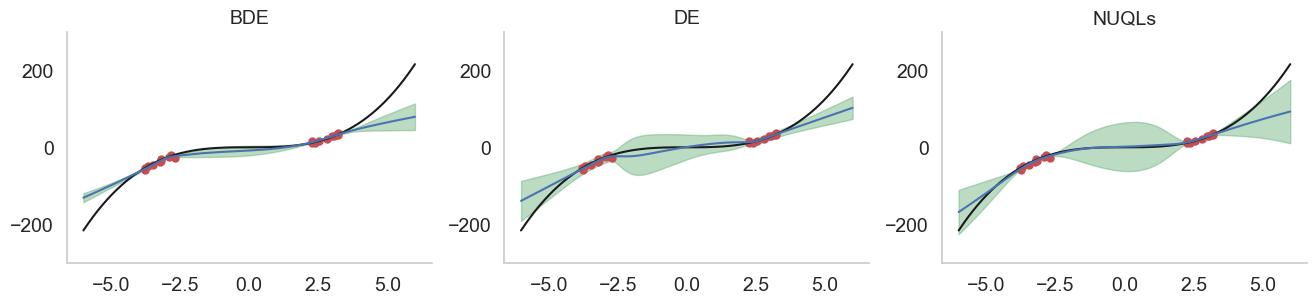

In [20]:
fs, ms, lw = 14, 5, 1.5

# plt.rc('xtick', labelsize=10) 
# plt.rc('ytick', labelsize=10) 

f, (ax1,ax2,ax3) = plt.subplots(1,3)

f.set_figheight(3)
f.set_figwidth(16)
f.subplots_adjust(hspace=0.5)

## Plot BDE
plot_bayes_method(ax1,bde_mean,bde_var,'BDE',fs=fs, ms=ms, lw=lw)

## Plot DE
plot_bayes_method(ax2,ensemble_het_mu_mean,ensemble_het_var_mean,'DE',fs=fs, ms=ms, lw=lw)

## Plot NUQLs
plot_bayes_method(ax3,nuql_mu,nuql_var,'NUQLs',fs=fs, ms=ms, lw=lw)

plt.savefig("UncertaintyComparison_bde.pdf", format="pdf", bbox_inches="tight")
plt.show()